In [1]:
%pip install neuralforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 636.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer, TimeMixer
from neuralforecast.losses.pytorch import MAE
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive


In [ ]:
# Custom callback to save training losses at each epoch
class SaveTrainingLossCallback(pl.Callback):
    def __init__(self, log_file='epoch_loss_log_window_itransformer_model_one_year.txt'):
        self.training_losses = []
        self.log_file = log_file
        self.window_number = 0
        with open(self.log_file, 'w') as f:
            f.write('Epoch,Train_Loss,Window\n')

    def on_train_epoch_end(self, trainer, pl_module):
        # Save the training loss at the end of each epoch
        train_loss = trainer.callback_metrics['train_loss'].item()
        self.training_losses.append(train_loss)
        print(f"Epoch {trainer.current_epoch}: Train Loss = {train_loss}")

        # Log the loss to the file
        with open(self.log_file, 'a') as f:
            f.write(f'{trainer.current_epoch},{train_loss},{self.window_number}\n')

    def set_window_number(self, window_number):
        self.window_number = window_number

# Initialize callbacks
save_loss_callback = SaveTrainingLossCallback()
pl_trainer_kwargs = {"callbacks": [save_loss_callback], "accelerator": "cpu", "devices": 1}

In [ ]:

# Load and preprocess the data
csv_file_path = '/content/drive/My Drive/archive/SBIN.NS_day.csv'
sbi_data = pd.read_csv(csv_file_path, parse_dates=['Date'])
sbi_data.dropna(inplace=True)
sbi_data.set_index('Date', inplace=True)
sbi_data = sbi_data.asfreq('B', method='pad')

# Create scalers
scaler_close = MinMaxScaler()
sbi_data['Open_Close_Diff'] = sbi_data['Open'] - sbi_data['Close']
sbi_data['Close'] = scaler_close.fit_transform(sbi_data[['Close']])

# Initialize variables
training_end_date = sbi_data.index.max() - pd.DateOffset(years=1)  # Train using last 1 year of data
final_predictions = []



In [ ]:
# Define the window management and model training class
class ModelTrainer:
    def __init__(self, data, scaler_close, save_loss_callback, pl_trainer_kwargs):
        self.data = data
        self.scaler_close = scaler_close
        self.save_loss_callback = save_loss_callback
        self.pl_trainer_kwargs = pl_trainer_kwargs

    def train_model(self, train_data, window_number):
        # Set the window number for the callback
        self.save_loss_callback.set_window_number(window_number)

        # Prepare the training data
        Y_train_df = train_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
        Y_train_df['unique_id'] = 'SBIN'

        # Initialize and train the iTransformer model
        model = TimeMixer(
            h=7,  # Forecast horizon
            input_size=60,  # Considered autoregressive inputs
            n_series=1,  # Number of time-series
            d_model=512,  # Dimension of the model (similar to hidden_size in iTransformer)
            d_ff=2048,  # Dimension of the fully-connected network
            dropout=0.1,  # Dropout rate
            e_layers=2,  # Number of encoder layers
            loss=MAE(),  # Loss function
            learning_rate=0.001,
            max_steps=500,
            use_norm=True,
            **{'callbacks': [self.save_loss_callback]}  # Pass the callback directly here
        )
        # NeuralForecast object to handle model training
        nf = NeuralForecast(models=[model], freq='B')
        nf.fit(df=Y_train_df)

        # Generate future dataframe automatically
        futr_df = nf.make_future_dataframe()

        # Generate predictions
        forecasts = nf.predict(futr_df=futr_df)

        pred_values = self.scaler_close.inverse_transform(forecasts[['TimeMixer']].values)
        dates = futr_df['ds']

        return dates, pred_values


In [ ]:
# Initialize the trainer
trainer = ModelTrainer(sbi_data, scaler_close, save_loss_callback, pl_trainer_kwargs)

# Training and prediction loop
window_number = 1
while True:
    train_data = sbi_data.loc[:training_end_date]
    print(f"Training window {window_number}: from {train_data.index.min()} to {train_data.index.max()}")

    # Train the model and get predictions
    dates, pred_values = trainer.train_model(train_data, window_number)

    if len(dates) == 0:
        print("No future dates were generated. Exiting the loop.")
        break

    # Store the predictions
    predictions_df = pd.DataFrame({'Date': dates, 'Predicted Value': pred_values.flatten()})
    final_predictions.append(predictions_df)

    # Update training_end_date for the next window only if dates exist
    training_end_date = dates.iloc[-1] if len(dates) > 0 else training_end_date

    # Break if we reach the end of the data
    if training_end_date >= sbi_data.index.max():
        break

    window_number += 1

NameError: name 'ModelTrainer' is not defined

In [ ]:
# Combine predictions and save
all_predictions_df = pd.concat(final_predictions, ignore_index=True)
output_csv_file = '/content/drive/My Drive/archive/prediction_using_window_method_TimeMixer_model_one_year.csv'
all_predictions_df.to_csv(output_csv_file, index=False)

print(f"Predictions saved to {output_csv_file}")

# Print the logged training losses
print("Training Losses:", save_loss_callback.training_losses)


Predictions saved to /content/drive/My Drive/archive/prediction_using_window_method_itransformer_model_one_year.csv
Training Losses: []


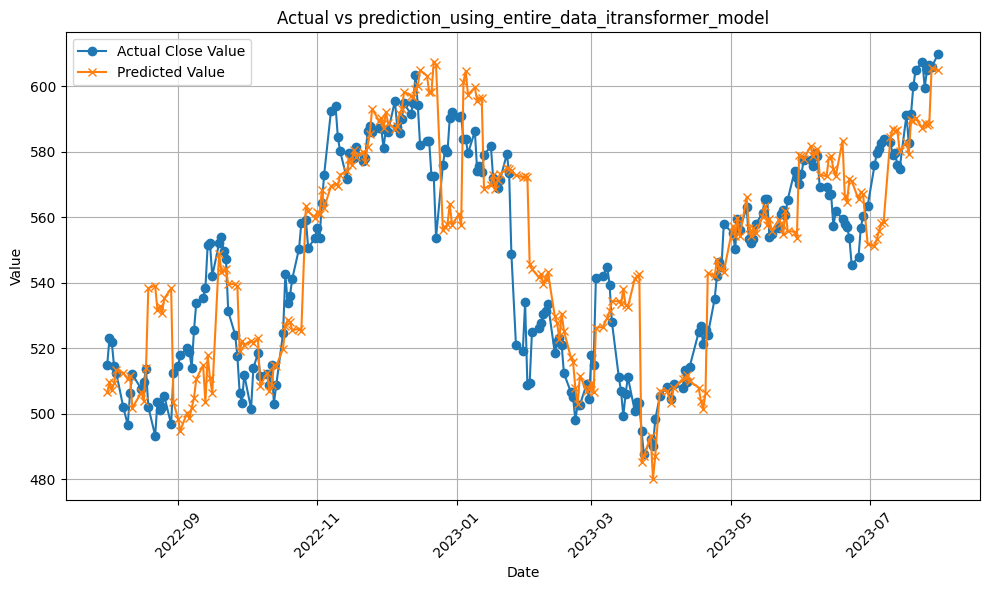

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

# Load the actual data from the CSV file
#actual_csv_path = '/home/raj/Rajarshi/Term Project/notebook_files/data/SBIN.NS_day_2023.csv'
actual_csv_path = csv_file_path
actual_df = pd.read_csv(actual_csv_path)

# Load the predicted data from the CSV file
#predicted_csv_path = '/home/raj/Rajarshi/Term Project/rajarshi_code/itransformer_file/prediction_using_entire_data_itransformer_model.csv'
predicted_csv_path = output_csv_file
predicted_df = pd.read_csv(predicted_csv_path)

# Convert the 'Date' columns to a consistent datetime format for both DataFrames
actual_df['Date'] = pd.to_datetime(actual_df['Date'], errors='coerce')
predicted_df['Date'] = pd.to_datetime(predicted_df['Date'], errors='coerce')

# Drop rows with invalid dates (NaT)
actual_df = actual_df.dropna(subset=['Date'])
predicted_df = predicted_df.dropna(subset=['Date'])

# Merge the DataFrames on the 'Date' column, keeping only the matching dates
merged_df = pd.merge(predicted_df, actual_df, on='Date', how='inner')

# Print the matched dates for verification
# print("Matched Dates:\n", merged_df['Date'])

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Actual Close Value', marker='o')
plt.plot(merged_df['Date'], merged_df['Predicted Value'], label='Predicted Value', marker='x')

# If 'Window Start' and 'Window End' columns are present, add vertical markers
if 'Window Start' in predicted_df.columns and 'Window End' in predicted_df.columns:
    for i in range(len(predicted_df)):
        plt.axvline(predicted_df['Window Start'].iloc[i], color='green', linestyle='--', label='Window Start' if i == 0 else '')
        plt.axvline(predicted_df['Window End'].iloc[i], color='red', linestyle='--', label='Window End' if i == 0 else '')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
title = 'Actual vs prediction_using_entire_data_TimeMixer_model'
plt.title(title)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()

# Specify the folder where you want to save the plot
output_folder = '/content/drive/My Drive/archive/'

# Ensure the folder exists, if not, create it
os.makedirs(output_folder, exist_ok=True)

# Use the plot title for the filename, replacing spaces with underscores and converting to lowercase
filename = f'{title.replace(" ", "_").lower()}.png'

# Save the plot in the specified folder with the generated filename
plt.savefig(os.path.join(output_folder, filename), format='png', dpi=300)

# Show the plot
plt.show()